In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time 
import math

sns.set_style("darkgrid")

from IPython.display import clear_output

start = time.time()

In [2]:
data_folder = "prepared_data"
destination_folder = "EDA_figures"
local_directory = os.getcwd()

if data_folder not in os.listdir(local_directory):
    print(data_folder, os.listdir(local_directory))
    raise Exception(f"{data_folder} folder not found, please create it first.")
    
filename_list = os.listdir(f'{local_directory}\\{data_folder}')
if len(filename_list) < 0:
    raise Exception(f"Required files not present in {data_folder}")
    
if destination_folder in os.listdir(local_directory):
    confirm = input(f"{destination_folder} already exists!, are you sure you want to run the code again?\nY/N:")
    if confirm.upper() != 'Y':
        raise SystemExit("Cancelling runtime!")
else:
    os.mkdir(f'{local_directory}\\{destination_folder}')

EDA_figures already exists!, are you sure you want to run the code again?
Y/N:y


# Load the prepared data

In [3]:
df_list = []
df_dict = {}
merged_df = pd.read_csv(f'{local_directory}\\{data_folder}\\merged_disease_data.csv',index_col=0)

for i, filename in enumerate(filename_list):
    clear_output(wait=True)
    
    print(f"Files read/Total files: {i+1}/{len(filename_list)}")
    df_name = filename.split('.')[0].lower()
    print(f"Reading: {filename}")
    
    if (df_name=='merged_disease_data'):
        continue
    
    df = pd.read_csv(f'{local_directory}\\{data_folder}\\{filename}',index_col=0)
    df_list.append(df_name)
    df_dict[df_name] = df
    globals()[df_name] = df

print("done! \nfiles loaded:")

df_list = ['dengue fever','leptospirosis','typhoid fever']
df_list

Files read/Total files: 10/10
Reading: TYPHOID FEVER.csv
done! 
files loaded:


['dengue fever', 'leptospirosis', 'typhoid fever']

In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12450 entries, 0 to 12449
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 12450 non-null  int64  
 1   week                 12450 non-null  int64  
 2   month                12450 non-null  int64  
 3   adm3_pcode           12450 non-null  object 
 4   adm3_en              12450 non-null  object 
 5   tave                 12450 non-null  float64
 6   tmin                 12450 non-null  float64
 7   tmax                 12450 non-null  float64
 8   heat_index           12450 non-null  float64
 9   pr                   12450 non-null  float64
 10  wind_speed           12450 non-null  float64
 11  rh                   12450 non-null  float64
 12  solar_rad            12450 non-null  float64
 13  uv_rad               12450 non-null  float64
 14  clinic_nearest       12450 non-null  float64
 15  dentist_nearest      12450 non-null  floa

# Data Cleaning

In [5]:
standard_average_columns = [
    'clinic_nearest',
    'dentist_nearest',
    'doctors_nearest',
    'hospital_nearest',
    'optician_nearest',
    'pharmacy_nearest',
    'pop_count_total',
    'pop_density_mean'
]

fill_zero_columns = [
    'case_total'
]

for i, df_name in enumerate(df_list):
    df = df_dict[df_name]
    for x in standard_average_columns:
        df[x] = df[x].fillna(df[x].mean())
    df_dict[df_name] = df
    
for i, df_name in enumerate(df_list):
    df = df_dict[df_name]
    for x in fill_zero_columns:
        df[x] = df[x].fillna(0)
    df_dict[df_name] = df
    
df = merged_df
for x in standard_average_columns:
    df[x] = df[x].fillna(df[x].mean())
merged_df = df

df = merged_df
for x in fill_zero_columns:
    df[x] = df[x].fillna(0)
merged_df = df

# Correlation Map    

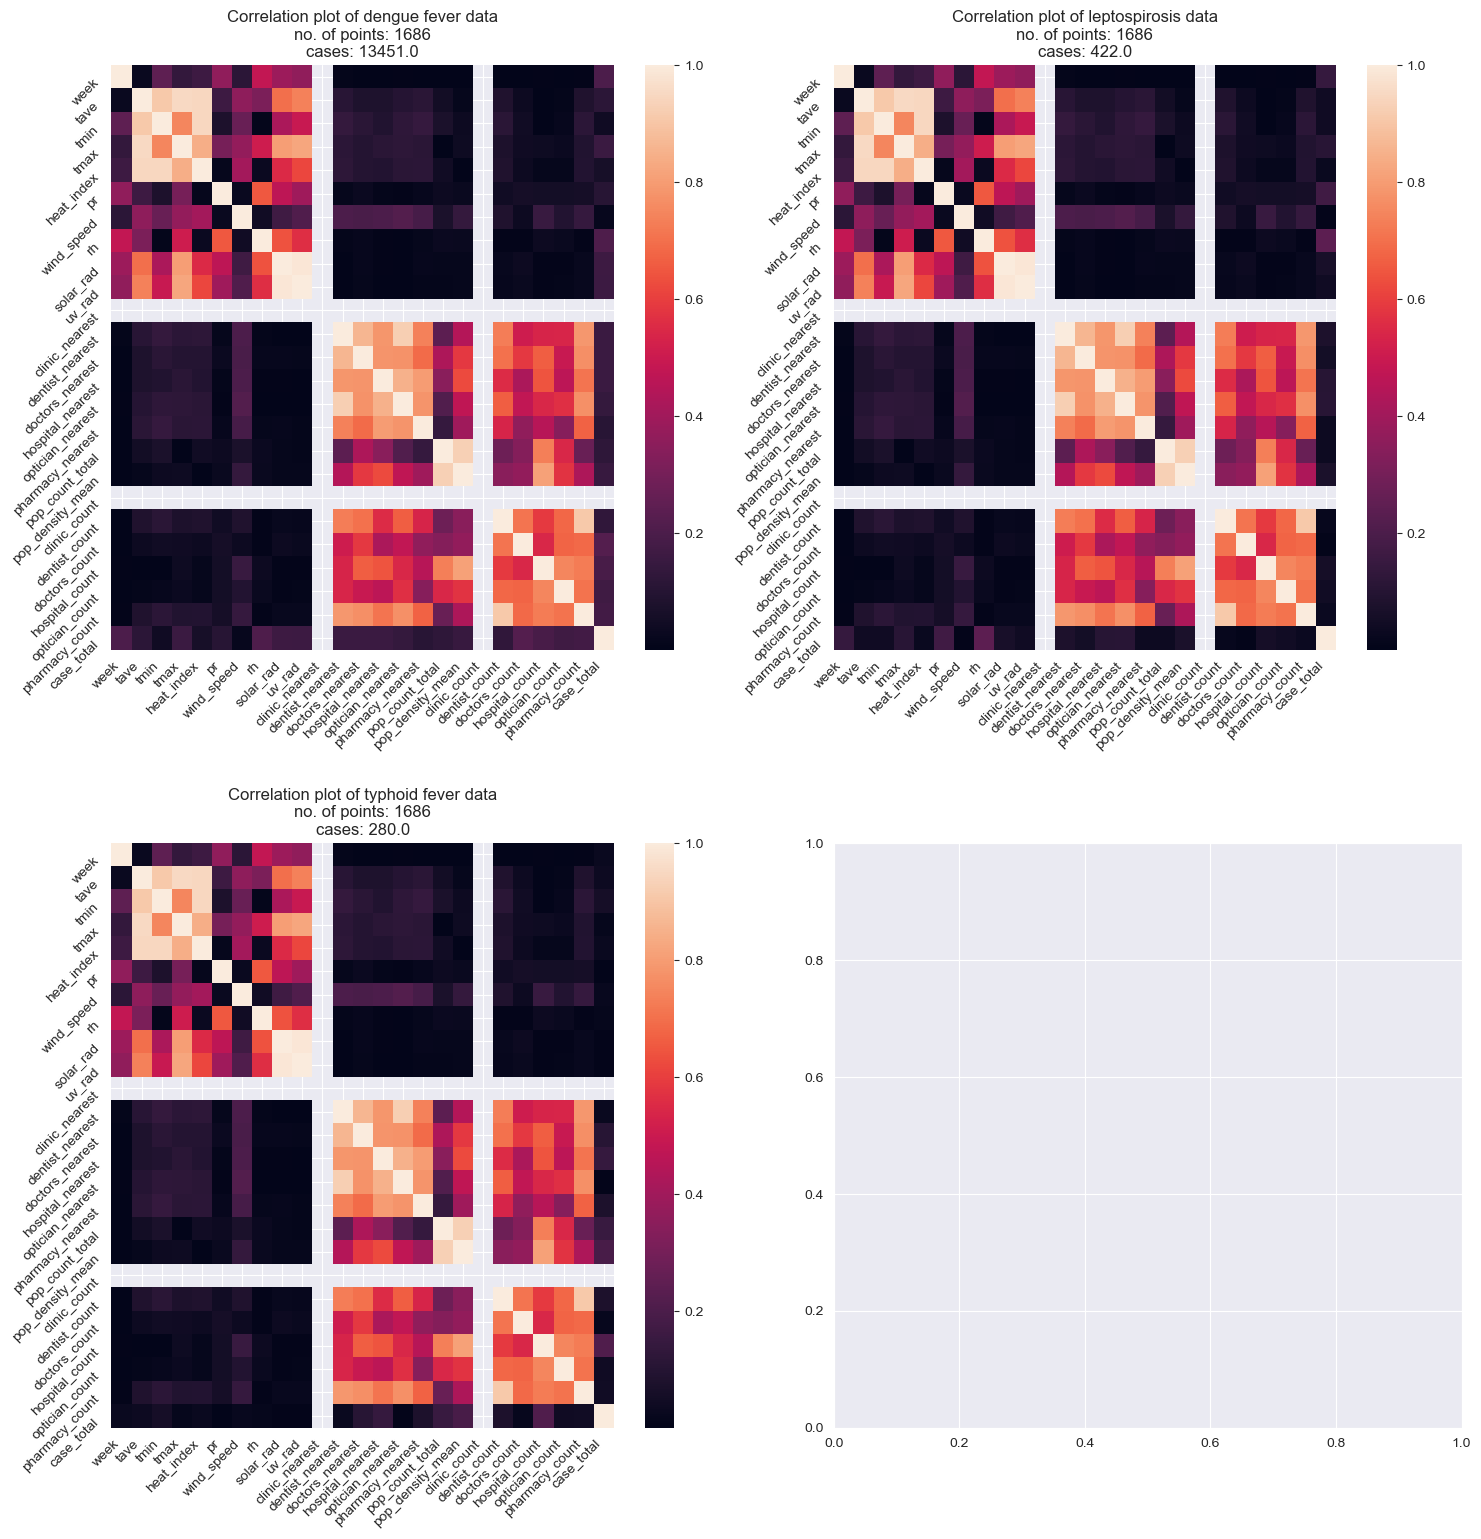

In [6]:
c = 2
r = math.ceil(len(df_list)/c)
fig, ax = plt.subplots(r, c, figsize=(15,(15/c)*r))
fig.tight_layout(pad = 4,h_pad=12)
disease_keys = df_list

for x in range(r):
    for y in range(c):
        index = (y+x*c)
        if index >= len(disease_keys):
            continue;
        disease = disease_keys[index]
        try:
            heatmap_data = df_dict[disease].drop(['year','month','adm3_pcode','adm3_en'],axis=1).corr()
            heatmap_data = heatmap_data.apply(lambda i: abs(i))
        except:
            print("\n",df_dict[disease])
        sns.heatmap(heatmap_data, vmax=1, ax=ax[x, y])
        ax[x, y].set_xticks(ax[x, y].get_xticks(),rotation=45,labels=ax[x, y].get_xticklabels(),ha='right',va='top')
        ax[x, y].set_yticks(ax[x, y].get_yticks(),rotation=45,labels=ax[x, y].get_yticklabels(),ha='right',va='top')
        ax[x, y].set_title(f"Correlation plot of {disease} data\nno. of points: {len(df_dict[disease])}\ncases: {df_dict[disease]['case_total'].sum()}")
        ax[x, y].plot()
        
fig_folder = 'corr_maps'

if fig_folder not in os.listdir(f'{local_directory}\\{destination_folder}'):
    os.mkdir(f'{local_directory}\\{destination_folder}\\{fig_folder}')
        
for x in range(r):
    for y in range(c):
        clear_output(wait=True)
        index = (y+x*c)
        if index >= len(disease_keys):
            continue;
        disease = disease_keys[index]
        
        filename = f'{local_directory}\\{destination_folder}\\{fig_folder}\\{disease} corr map.png'
        extent = ax[x, y].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        print(f'{index+1}/{len(disease_keys)}')
        print(f'saving {filename}...')
        fig.savefig(filename, bbox_inches=extent.expanded(1.5, 1.35)) 

# Year-month case rates for every disease

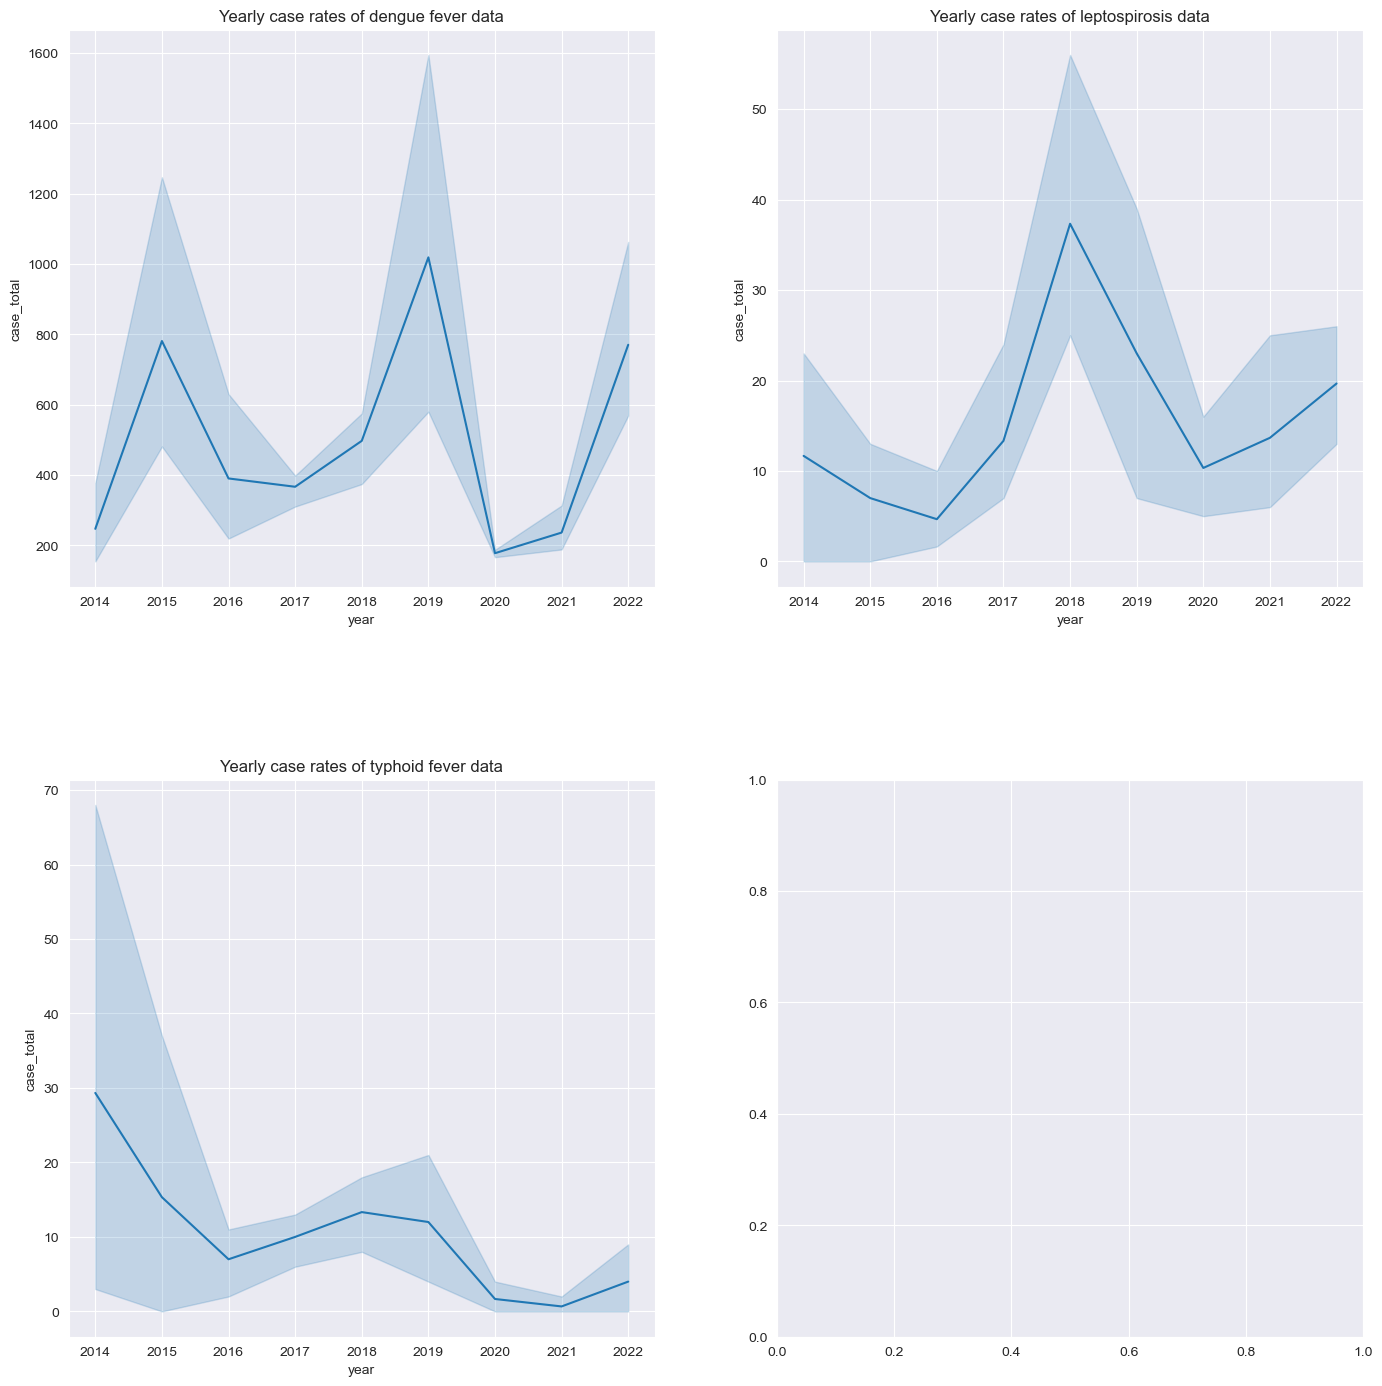

In [7]:
c = 2
r = math.ceil(len(df_list)/c)
fig, ax = plt.subplots(r, c, figsize=(15,(15/c)*r))
fig.tight_layout(pad = 6,h_pad=12)
disease_keys = df_list

for x in range(r):
    for y in range(c):
        index = (y+x*c)
        if index >= len(disease_keys):
            continue;
        disease = disease_keys[index]
        data = df_dict[disease]
        data = data.groupby(by=["year","adm3_en"]).sum().reset_index()

        sns.lineplot(data, x='year', y='case_total', ax=ax[x, y])
        ax[x, y].set_title(f"Yearly case rates of {disease} data")
        ax[x, y].plot()
        
fig_folder = 'yearly rates'

if fig_folder not in os.listdir(f'{local_directory}\\{destination_folder}'):
    os.mkdir(f'{local_directory}\\{destination_folder}\\{fig_folder}')
        
for x in range(r):
    for y in range(c):
        clear_output(wait=True)
        index = (y+x*c)
        if index >= len(disease_keys):
            continue;
        disease = disease_keys[index]
        
        filename = f'{local_directory}\\{destination_folder}\\{fig_folder}\\{disease} yearly rates.png'
        extent = ax[x, y].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        print(f'{index+1}/{len(disease_keys)}')
        print(f'saving {filename}...')
        fig.savefig(filename, bbox_inches=extent.expanded(1.2, 1.2)) 

# Seasonal trends in disease case totals

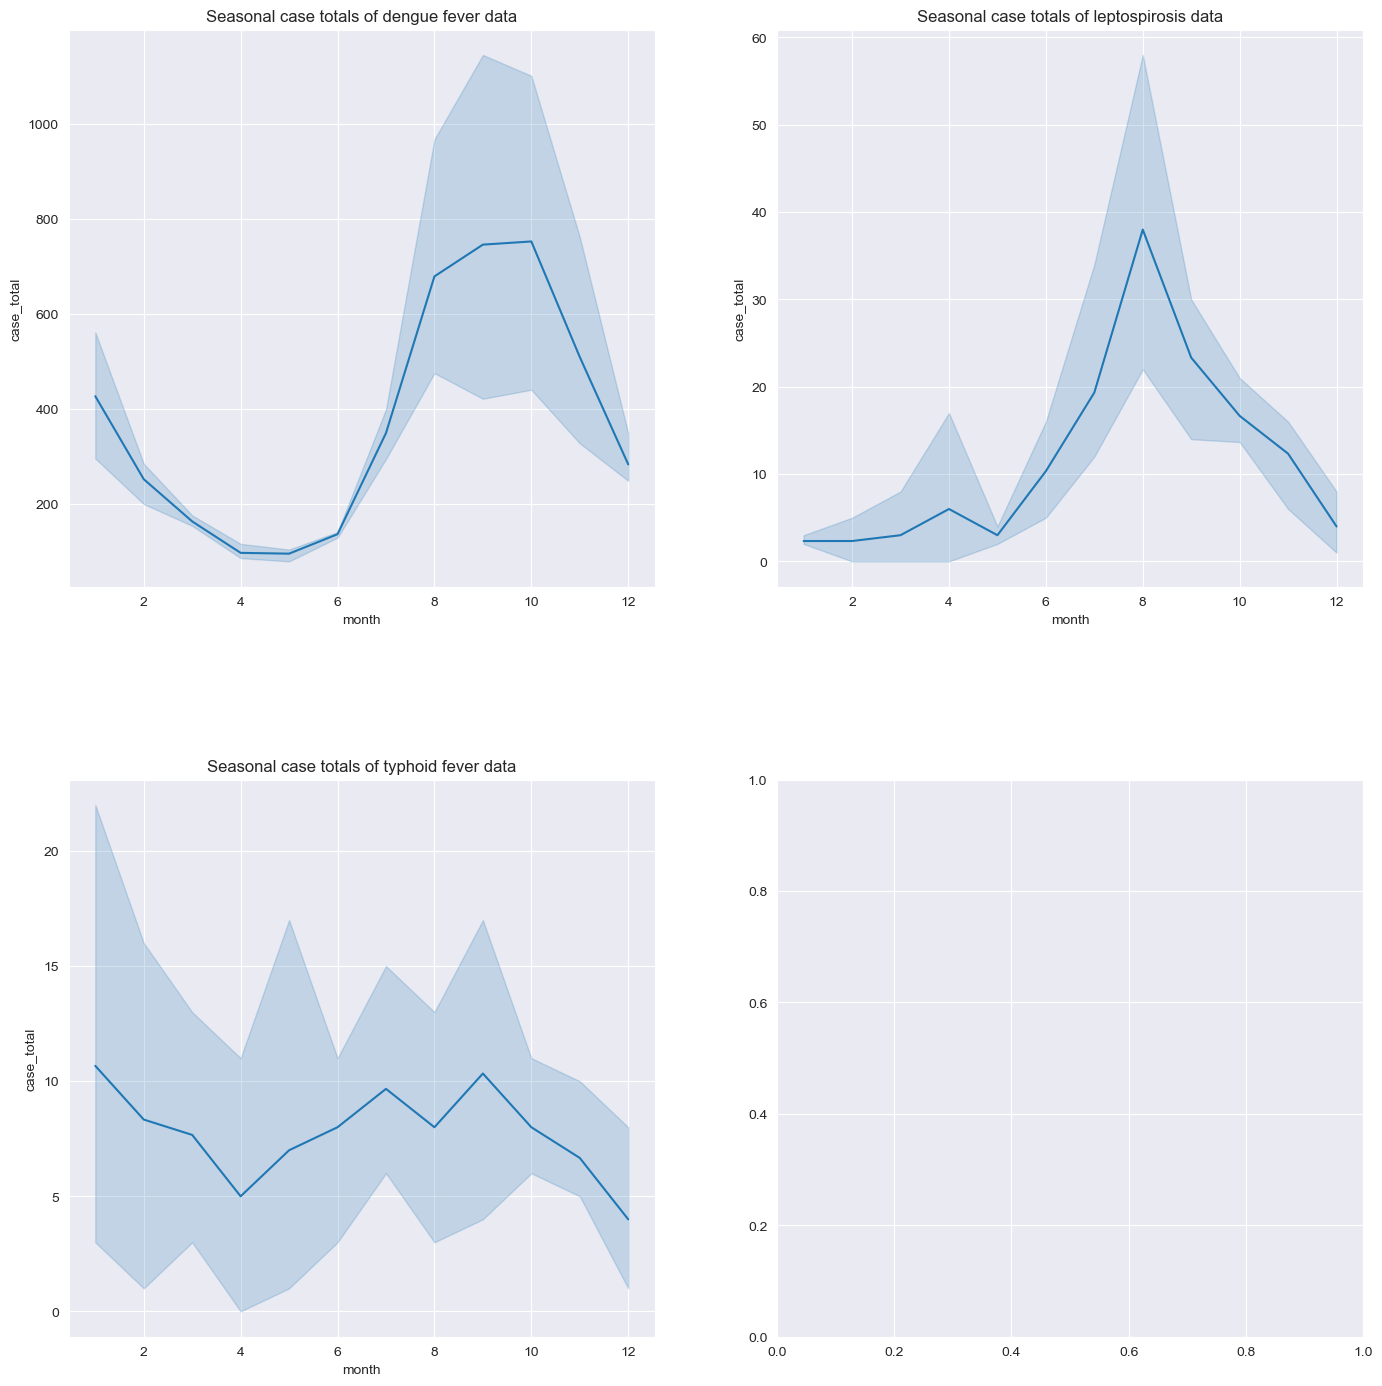

In [8]:
c = 2
r = math.ceil(len(df_list)/c)
fig, ax = plt.subplots(r, c, figsize=(15,(15/c)*r))
fig.tight_layout(pad = 6,h_pad=12)
disease_keys = df_list

for x in range(r):
    for y in range(c):
        index = (y+x*c)
        if index >= len(disease_keys):
            continue;
        disease = disease_keys[index]
        data = df_dict[disease]
        data = data.groupby(by=["month",'adm3_en']).sum().reset_index()

        sns.lineplot(data, x='month', y='case_total', ax=ax[x, y])
        ax[x, y].set_title(f"Seasonal case totals of {disease} data")
        ax[x, y].plot()
        
fig_folder = 'seasonal rates'

if fig_folder not in os.listdir(f'{local_directory}\\{destination_folder}'):
    os.mkdir(f'{local_directory}\\{destination_folder}\\{fig_folder}')     

for x in range(r):
    for y in range(c):
        clear_output(wait=True)
        index = (y+x*c)
        if index >= len(disease_keys):
            continue;
        disease = disease_keys[index]
        
        filename = f'{local_directory}\\{destination_folder}\\{fig_folder}\\{disease} seasonal rates.png'
        extent = ax[x, y].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        print(f'{index+1}/{len(disease_keys)}')
        print(f'saving {filename}...')
        fig.savefig(filename, bbox_inches=extent.expanded(1.2, 1.2)) 

# Dengue comparison over temperature

3/3
saving C:\Users\asus\Documents\GitHub\project-cchain\EDA_figures\disease-heat_index comparisons\typhoid fever-temp comparison per city.png...


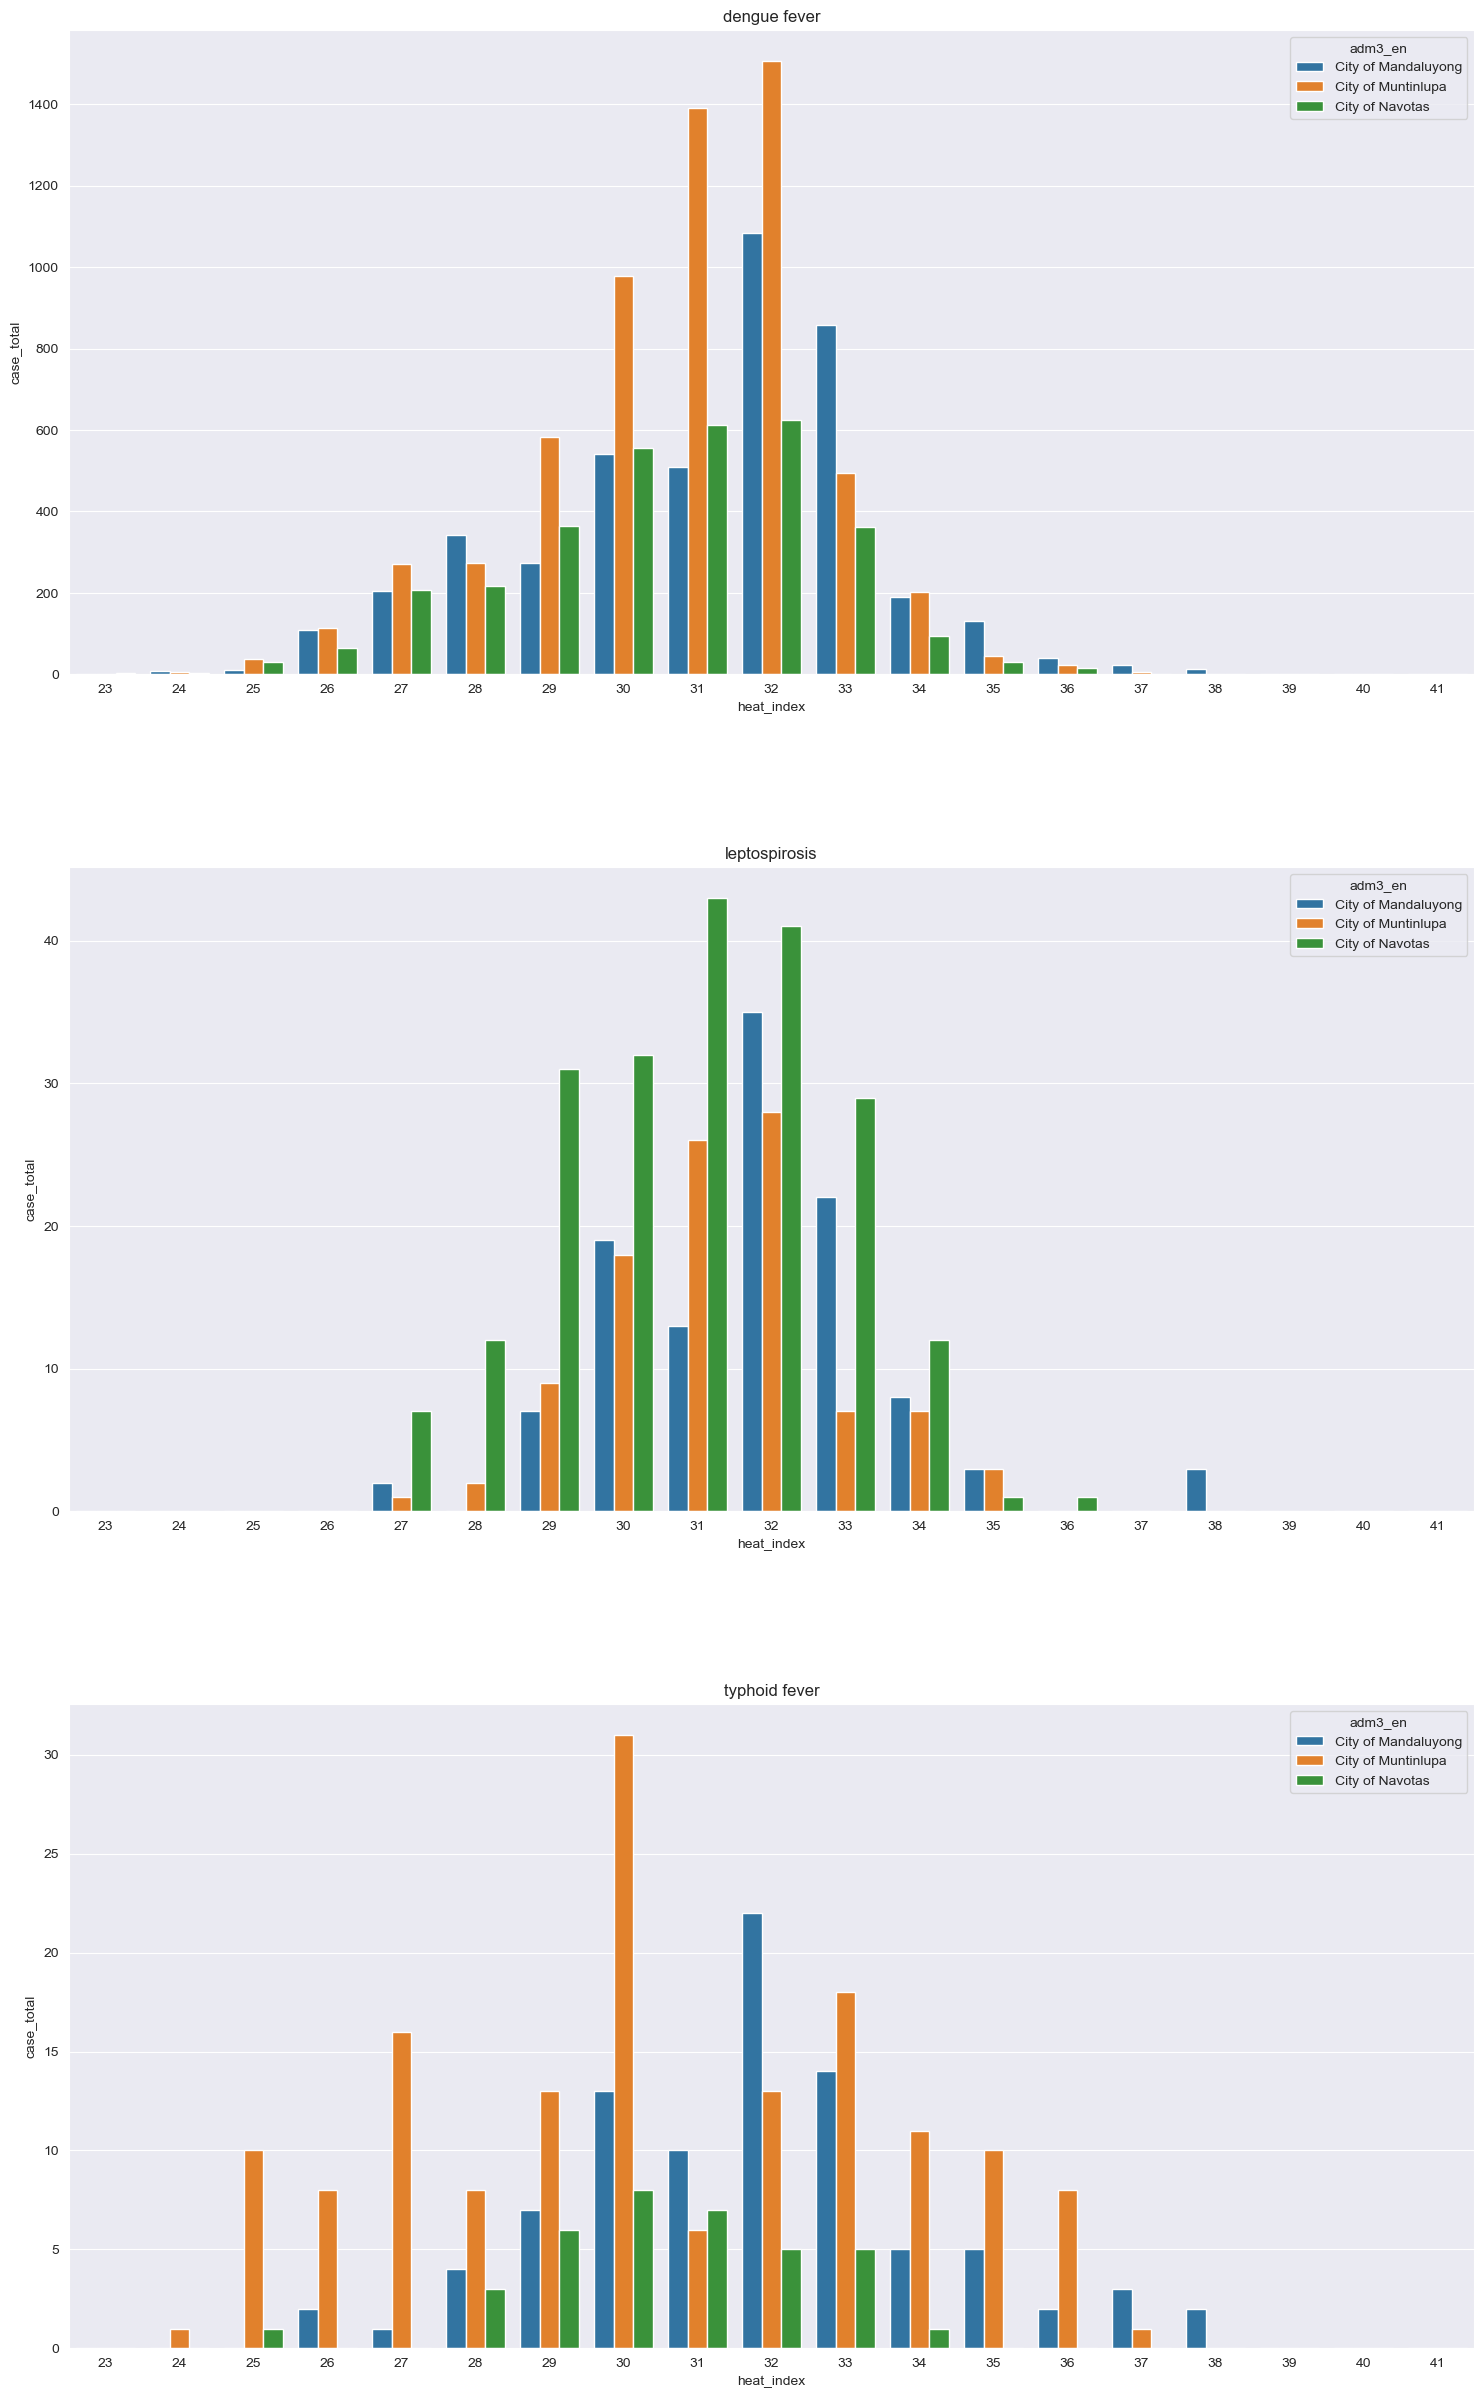

In [9]:
compare_columns = [
    'heat_index',
]

r = math.ceil(len(df_list))
c = len(compare_columns)
fig, ax = plt.subplots(r, c, figsize=(15,8*r))
fig.tight_layout(pad = 2,h_pad=12)
disease_keys = list(df_list)

for x in range(r):
    disease = disease_keys[x]
    for y in range(c):
        compare = compare_columns[y]
        df = df_dict[disease]
        df = df.dropna()
        steps = 15
        minimum = int(df[compare].min())
        maximum = int(df[compare].max())+5
        interval = 1

        data = df.groupby([pd.cut(df[compare], np.arange(minimum, maximum, interval)),'adm3_en'])['case_total'].sum().reset_index()
        data[compare] = data.apply(lambda x: x[compare].left, axis=1)
        sns.barplot(data, x=compare, y='case_total', hue='adm3_en', ax=ax[x])
        ax[x].set_title(f"{disease}")

fig_folder = 'disease-heat_index comparisons'

if fig_folder not in os.listdir(f'{local_directory}\\{destination_folder}'):
    os.mkdir(f'{local_directory}\\{destination_folder}\\{fig_folder}')     

for x in range(r):
    disease = disease_keys[x]
    for y in range(c):
        clear_output(wait=True)
        index = (y+x*c)
        if index >= len(disease_keys):
            continue;
        disease = disease_keys[index]
        
        filename = f'{local_directory}\\{destination_folder}\\{fig_folder}\\{disease}-temp comparison per city.png'
        extent = ax[x].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        print(f'{index+1}/{len(disease_keys)}')
        print(f'saving {filename}...')
        fig.savefig(filename, bbox_inches=extent.expanded(1.2, 1.2)) 

# Comparing heat index, pr, and rh against diseases over time.

12/12
saving C:\Users\asus\Documents\GitHub\project-cchain\EDA_figures\disease-climate yearly rate comparisons\typhoid fever-wind_speed comparison per city.png...


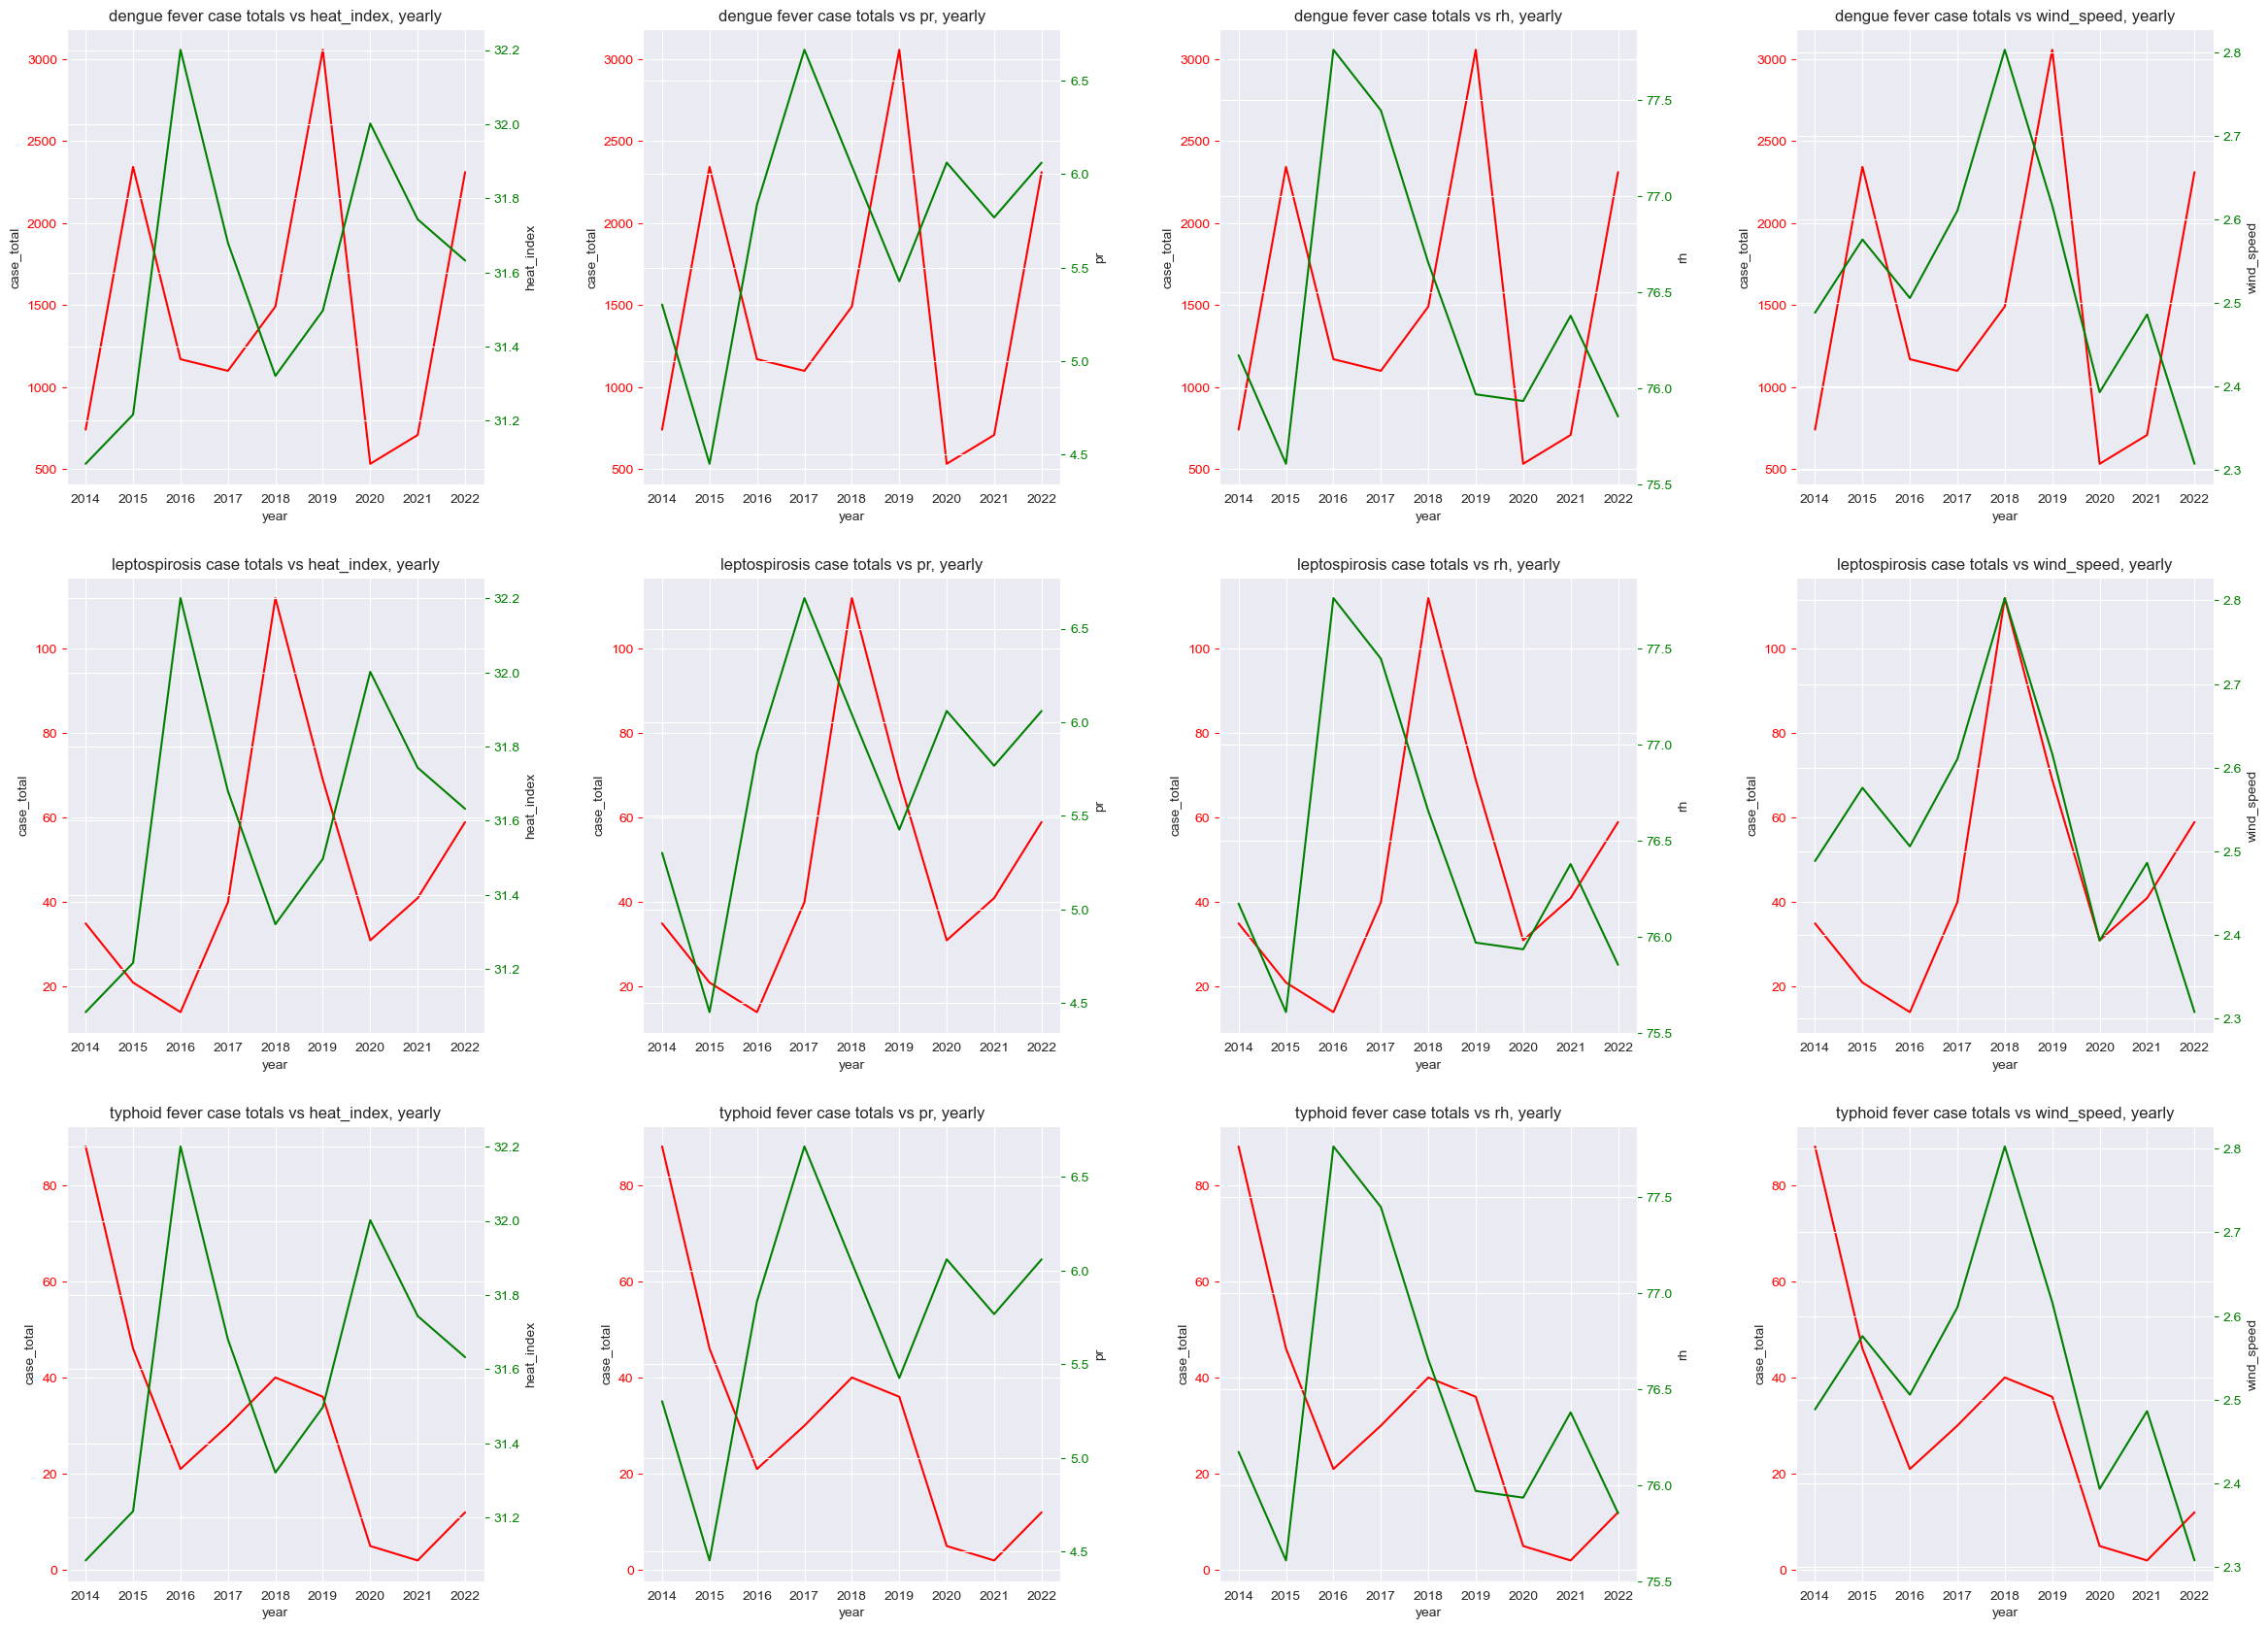

In [10]:
compare_columns = [
    'heat_index',
    'pr',
    'rh',
    'wind_speed'
]

r = math.ceil(len(df_list))
c = len(compare_columns)
fig, ax = plt.subplots(r, c,figsize=(25,(25/c)*r))
fig.tight_layout(pad = 9,h_pad=5)
disease_keys = list(df_list)

for x in range(r):
    disease = disease_keys[x]
    for y in range(c):
        compare = compare_columns[y]
        df = df_dict[disease]
        
        data = df.groupby(by=["year"])['case_total'].sum().reset_index()
        data2 = df.groupby(by=["year"])[compare].mean().reset_index()

        sns.lineplot(data=data, x='year', y='case_total', color="r", ax=ax[x,y])
        ax[x,y].tick_params(axis='y', colors='r')
        
        ax2 = ax[x,y].twinx()
        sns.lineplot(data=data2, x='year', y=compare, color="g", ax=ax2)
        ax2.tick_params(axis='y', colors='g')
        
        ax[x, y].set_title(f'{disease} case totals vs {compare}, yearly')

fig_folder = 'disease-climate yearly rate comparisons'

if fig_folder not in os.listdir(f'{local_directory}\\{destination_folder}'):
    os.mkdir(f'{local_directory}\\{destination_folder}\\{fig_folder}')     

for x in range(r):
    disease = disease_keys[x]
    for y in range(c):
        index = (y+x*c)
        clear_output(wait=True)
        compare = compare_columns[y]
        
        filename = f'{local_directory}\\{destination_folder}\\{fig_folder}\\{disease}-{compare} comparison per city.png'
        extent = ax[x,y].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        print(f'{index+1}/{r*c}')
        print(f'saving {filename}...')
        fig.savefig(filename, bbox_inches=extent.expanded(1.3, 1.25)) 

12/12
saving C:\Users\asus\Documents\GitHub\project-cchain\EDA_figures\disease-climate seasonal rate comparisons\typhoid fever-wind_speed comparison per city.png...


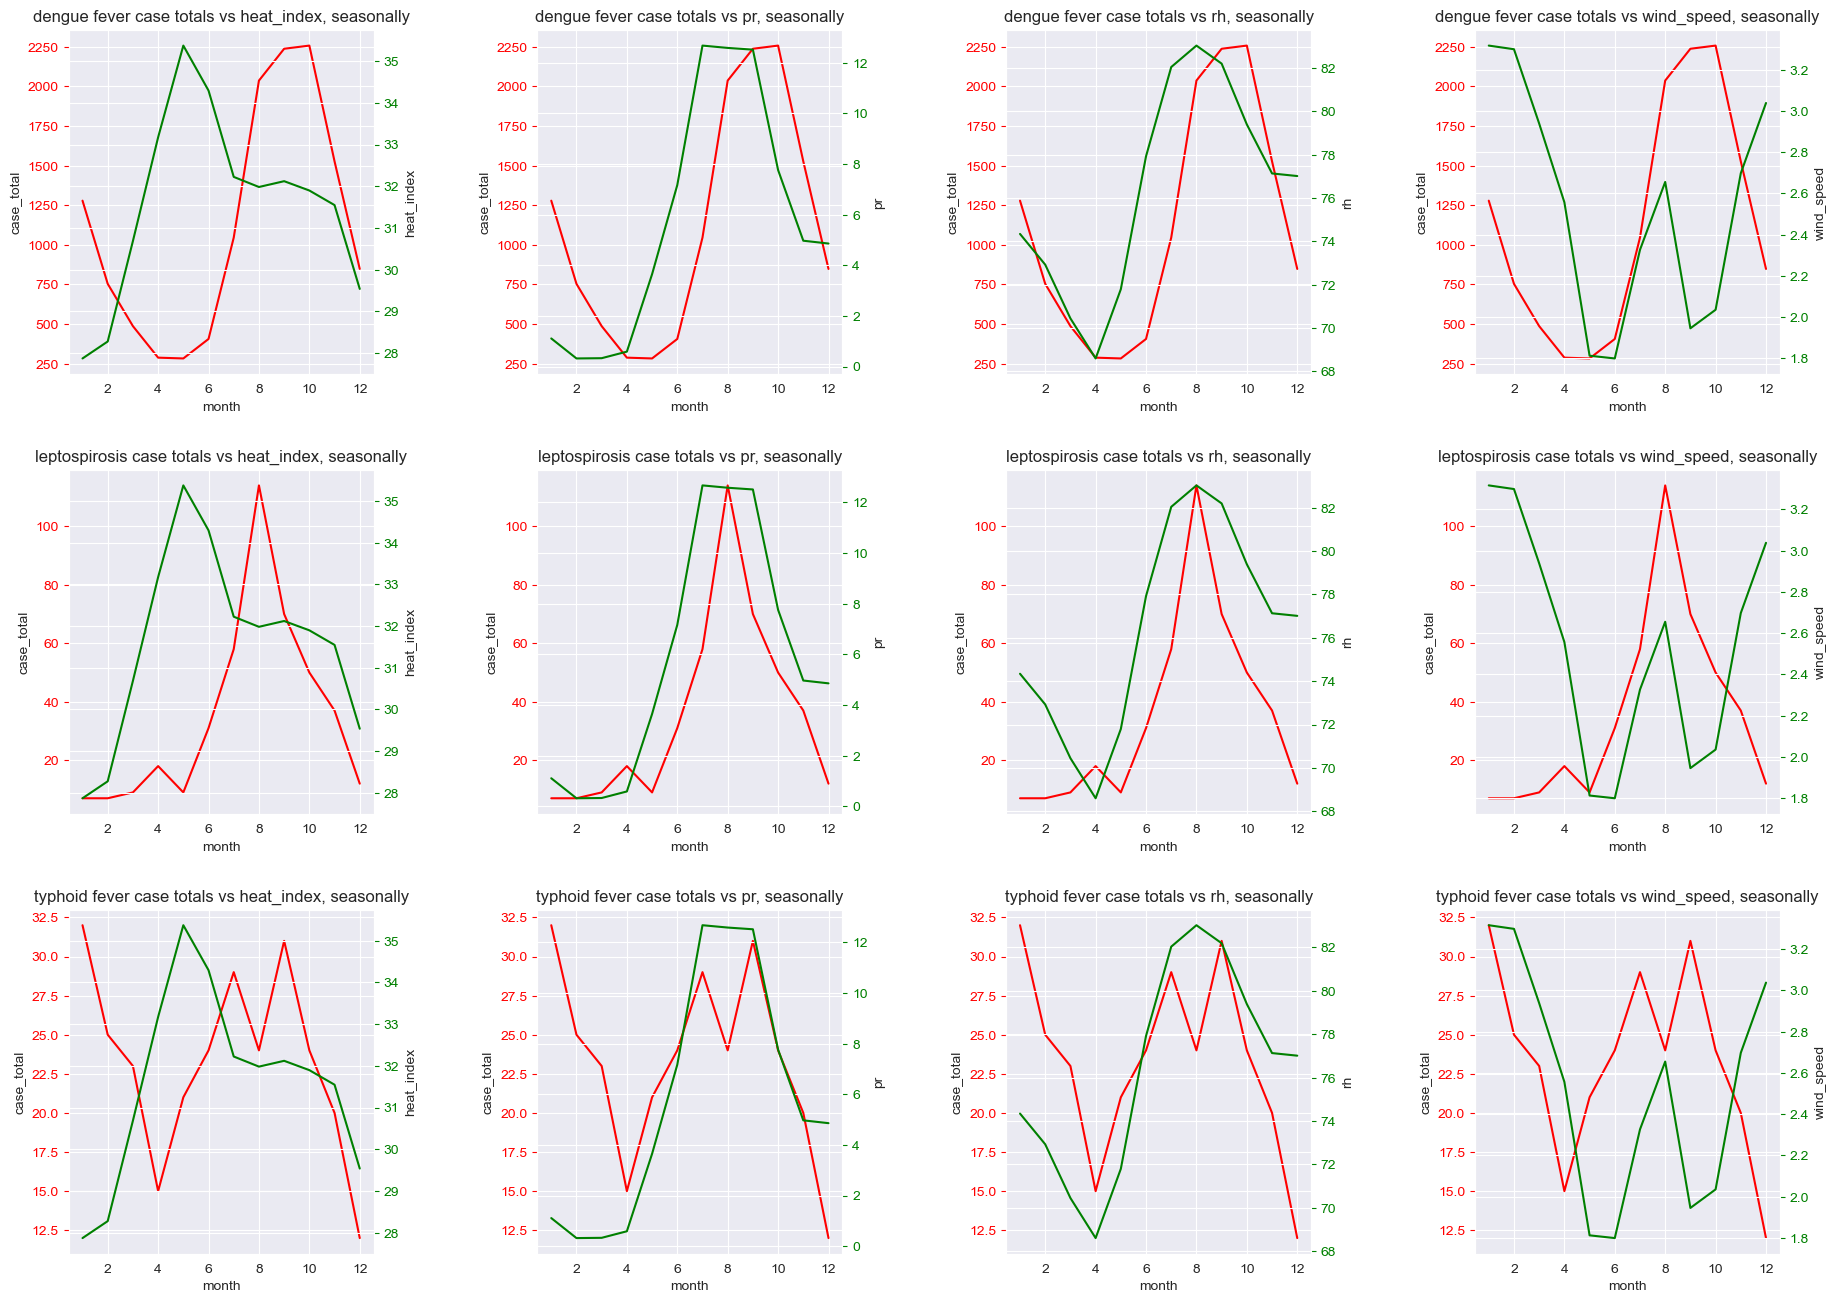

In [11]:
compare_columns = [
    'heat_index',
    'pr',
    'rh',
    'wind_speed'
]

r = math.ceil(len(df_list))
c = len(compare_columns)
fig, ax = plt.subplots(r, c, figsize=(20,(20/c)*r))
fig.tight_layout(pad = 9,h_pad=5)
disease_keys = list(df_list)

for x in range(r):
    disease = disease_keys[x]
    for y in range(c):
        compare = compare_columns[y]
        df = df_dict[disease]
        
        data = df.groupby(by=["month"])['case_total'].sum().reset_index()
        data2 = df.groupby(by=["month"])[compare].mean().reset_index()

        sns.lineplot(data=data, x='month', y='case_total', color="r", ax=ax[x,y])
        ax[x,y].tick_params(axis='y', colors='r')
        
        ax2 = ax[x,y].twinx()
        sns.lineplot(data=data2, x='month', y=compare, color="g", ax=ax2)
        ax2.tick_params(axis='y', colors='g')
        
        ax[x, y].set_title(f'{disease} case totals vs {compare}, seasonally')
        
fig_folder = 'disease-climate seasonal rate comparisons'

if fig_folder not in os.listdir(f'{local_directory}\\{destination_folder}'):
    os.mkdir(f'{local_directory}\\{destination_folder}\\{fig_folder}')     

for x in range(r):
    disease = disease_keys[x]
    for y in range(c):
        index = (y+x*c)
        clear_output(wait=True)
        compare = compare_columns[y]
        
        filename = f'{local_directory}\\{destination_folder}\\{fig_folder}\\{disease}-{compare} comparison per city.png'
        extent = ax[x,y].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        print(f'{index+1}/{r*c}')
        print(f'saving {filename}...')
        fig.savefig(filename, bbox_inches=extent.expanded(1.4, 1.25)) 

In [12]:
stop = time.time()
print(f"Total execution time: {time.strftime('%H:%M:%S', time.gmtime(stop-start))}")

Total execution time: 00:02:48
